## Encoder generator: 002

In [1]:
import os

import random
import numpy
from datetime import datetime

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import torch

import sys
sys.path.append("..")

from wordsToNumbers import Corpus
from wordsToNumbers import fibonacci_vocabulary

from wordsToQubits import put_word_on_sphere

from utils import get_corpus_from_directory, working_window, get_word_from_sphere

from qencode.initialize import setAux
from qencode.encoders import e2_classic
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from training.cost.swap_cost import sw_cost, sw_fidelity

In [2]:
np.random.seed(73)

## Corpus

In [3]:
"""
corpus_path="C:/Users/tomut/Documents/GitHub/Qountry/CountryMixt/"

corpus_tex = get_corpus_from_directory(corpus_path, limit=1)

corpus= Corpus(corpus_tex)
print(corpus.prop())
"""
corpus_text = "Same old dive, same old end of the work week drink Bartender knows my name, but I don't mind She kicks 'em up strong, serves me up right And here I go again I'm drinkin' one, I'm drinkin' two I got my heartache medication, a strong dedication To gettin' over you, turnin' me loose On that hardwood jukebox lost in neon time My heartache medication, well it suits me fine And I'm drinkin' enough to take you off my mind I got my heartache medication"
corpus= Corpus(corpus_text)
print(corpus.prop())

nr. words:85 
nr. distinct words: 59 
len.text/len.vocab:1.4406779661016949


In [4]:
parameterize_vovabulary = fibonacci_vocabulary(corpus.vocabulary)

## Training set 

In [5]:
history_lenghth = 3

In [6]:
x,y = working_window(history_lenghth, splited_text=corpus.split_text)

In [7]:
print("len training set:", len(x))

len training set: 81


## Working principles

## Just a simple encoder

### BIG encoder

In [8]:
shots = 2500
nr_trash=2
nr_latent=2

spec_big = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=0)
print("Qubits:", spec_big.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec_big.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6]


In [9]:
parameterize_vovabulary = fibonacci_vocabulary(corpus.vocabulary)

In [10]:
# circuit initializer
def circuit_initializer(words, qubits):
    
    for i in range(len(words)):
        put_word_on_sphere(words[i], qubit=qubits[i])


@qml.qnode(dev)
def encoder_e2(init_params, encoder_params,spec=spec_big, reinit_state=None):
    #initilaization
    circuit_initializer(init_params,qubits= [*spec.latent_qubits, *spec.trash_qubits])
   
    
    #encoder
    for params in encoder_params:
        e2_classic(params, [*spec.latent_qubits, *spec_big.trash_qubits])

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

#### Training parameters

In [11]:
epochs = 1000

batch_size = 2
num_samples = 0.8 # proportion of the data used for training 

learning_rate = 0.0003
beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [12]:
training_data = []

for i in range(int(len(x)*num_samples)):
    w_l = [ parameterize_vovabulary[w] for w in x[i]]
    w_l.append(parameterize_vovabulary[y[i]])
    training_data.append(w_l)
training_data = torch.tensor(training_data)

test_data = [ ]
for i in range(int(len(x)*num_samples),len(x)):
    w_l=[parameterize_vovabulary[w] for w in x[i]]
    w_l.append(parameterize_vovabulary[y[i]])
    test_data.append(w_l)
test_data = torch.tensor(test_data)

print("data example:",training_data[0])

data example: tensor([[ 0.4424, -0.8966,  0.0226],
        [ 0.3145, -0.5517,  0.7725],
        [ 0.9526,  0.2759,  0.1282],
        [ 0.4424, -0.8966,  0.0226]])


In [13]:
def iterate_batches(X, batch_size):
   
    X1 = [x  for x in X]
    
    
    random.shuffle(X1)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [14]:
batch_list=iterate_batches(X=training_data, batch_size=2)
batch_list

[[tensor([[ 0.4424, -0.8966,  0.0226],
          [ 0.3145, -0.5517,  0.7725],
          [ 0.9526,  0.2759,  0.1282],
          [ 0.4424, -0.8966,  0.0226]]),
  tensor([[ 0.3145, -0.5517,  0.7725],
          [ 0.9526,  0.2759,  0.1282],
          [ 0.4424, -0.8966,  0.0226],
          [ 0.3145, -0.5517,  0.7725]])],
 [tensor([[ 0.4424, -0.8966,  0.0226],
          [ 0.3145, -0.5517,  0.7725],
          [ 0.6559,  0.3793, -0.6527],
          [ 0.4897,  0.1724,  0.8547]]),
  tensor([[ 0.3145, -0.5517,  0.7725],
          [ 0.6559,  0.3793, -0.6527],
          [ 0.4897,  0.1724,  0.8547],
          [ 0.2975, -0.5172, -0.8025]])],
 [tensor([[ 0.4897,  0.1724,  0.8547],
          [ 0.2975, -0.5172, -0.8025],
          [-0.3851,  0.0690,  0.9203],
          [ 0.0319,  0.9310, -0.3635]]),
  tensor([[ 0.2975, -0.5172, -0.8025],
          [-0.3851,  0.0690,  0.9203],
          [ 0.0319,  0.9310, -0.3635],
          [-0.9096,  0.4138,  0.0376]])],
 [tensor([[ 0.0319,  0.9310, -0.3635],
          

###  training

In [15]:
# initialize random encoder parameters
nr_encod_qubits = len(spec_big.trash_qubits) + len(spec_big.latent_qubits)
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

#print(qml.draw(encoder_e2)(init_params=training_data[0], encoder_params=encoder_params, spec=spec_big))

In [16]:
def cost(encoder_params, X):
    return sw_cost(encoder_params, input_data=X, circuit=encoder_e2, reinit_state=None)

def fidelity(encoder_params, X):
    
    return sw_fidelity(encoder_params, input_data=X, circuit=encoder_e2, reinit_state=None)
  
    
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        loss_training = cost(encoder_params, training_data )
        fidel = fidelity(encoder_params, training_data )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, test_data )
        fidel = fidelity(encoder_params, test_data )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        
        
        

        experiment_parameters={"experiment":"Encoder_002",
                               "date":datetime.now(),
                               "train_loss":loss_training,
                               "train_fidelity":fidel,
                               "params":encoder_params}
        
        f=open("Encoder_002_results/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()


C:\Users\tomut\anaconda3\envs\qountry\lib\site-packages\pennylane\math\multi_dispatch.py:65: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.6228186876970827 | Fidelity:0.626916932100199
Test-Epoch:0 | Loss:1.658458794912434 | Fidelity:0.6114185740079146
Epoch:5 | Loss:1.619014533754742 | Fidelity:0.6283707184884954
Test-Epoch:5 | Loss:1.654036093702527 | Fidelity:0.612872360797899
Epoch:10 | Loss:1.6153015319860498 | Fidelity:0.6297841875207387
Test-Epoch:10 | Loss:1.6499042487836533 | Fidelity:0.6142477593334769
Epoch:15 | Loss:1.6117411389248606 | Fidelity:0.6311321457857075
Test-Epoch:15 | Loss:1.6460921958560149 | Fidelity:0.6155305574671622
Epoch:20 | Loss:1.608394174929646 | Fidelity:0.6323924595215547
Test-Epoch:20 | Loss:1.6426243169280903 | Fidelity:0.6167074651827102
Epoch:25 | Loss:1.605300997339709 | Fidelity:0.633551757656326
Test-Epoch:25 | Loss:1.6394950818704521 | Fidelity:0.6177776015408288
Epoch:30 | Loss:1.6024784639884833 | Fidelity:0.6346057088840499
Test-Epoch:30 | Loss:1.6366802608446926 | Fidelity:0.6187487150764747
Epoch:35 | Loss:1.5999237897680216 | Fidelity:0.6355568921743315
Te

Test-Epoch:300 | Loss:1.5931528902297556 | Fidelity:0.6349120457379919
Epoch:305 | Loss:1.5445939316646384 | Fidelity:0.6560017622941643
Test-Epoch:305 | Loss:1.592384069876222 | Fidelity:0.6351800599842983
Epoch:310 | Loss:1.5439214681314308 | Fidelity:0.6562687626170636
Test-Epoch:310 | Loss:1.591626631931952 | Fidelity:0.6354432305764579
Epoch:315 | Loss:1.5432670971809974 | Fidelity:0.6565301019143416
Test-Epoch:315 | Loss:1.5908814297001062 | Fidelity:0.6357012406600251
Epoch:320 | Loss:1.5426306914456234 | Fidelity:0.6567857815420837
Test-Epoch:320 | Loss:1.5901492221122249 | Fidelity:0.6359538096850169
Epoch:325 | Loss:1.542012074780034 | Fidelity:0.6570358166254596
Test-Epoch:325 | Loss:1.5894306772814004 | Fidelity:0.6362006921654443
Epoch:330 | Loss:1.5414110269166894 | Fidelity:0.6572802350837302
Test-Epoch:330 | Loss:1.5887263765424537 | Fidelity:0.6364416762393796
Epoch:335 | Loss:1.5408272880443066 | Fidelity:0.6575190766564396
Test-Epoch:335 | Loss:1.5880368188554927 | F

Epoch:605 | Loss:1.5244884948348807 | Fidelity:0.6648266876536056
Test-Epoch:605 | Loss:1.5713915343139697 | Fidelity:0.6413038197340737
Epoch:610 | Loss:1.5243084830234055 | Fidelity:0.6649073455830379
Test-Epoch:610 | Loss:1.571353598341988 | Fidelity:0.6412909638288999
Epoch:615 | Loss:1.5241293295868799 | Fidelity:0.6649873231306059
Test-Epoch:615 | Loss:1.571321544480658 | Fidelity:0.641276206586558
Epoch:620 | Loss:1.523950941215916 | Fidelity:0.6650666620429233
Test-Epoch:620 | Loss:1.5712952218000011 | Fidelity:0.6412596060114476
Epoch:625 | Loss:1.5237732292055761 | Fidelity:0.66514540247369
Test-Epoch:625 | Loss:1.5712744837080466 | Fidelity:0.6412412179324665
Epoch:630 | Loss:1.5235961092672072 | Fidelity:0.6652235830326335
Test-Epoch:630 | Loss:1.571259187841905 | Fidelity:0.641221096069823
Epoch:635 | Loss:1.523419501345885 | Fidelity:0.6653012408340367
Test-Epoch:635 | Loss:1.5712491959561816 | Fidelity:0.6411992921032262
Epoch:640 | Loss:1.5232433294435668 | Fidelity:0.6

Test-Epoch:905 | Loss:1.575852131272632 | Fidelity:0.6384526713925125
Epoch:910 | Loss:1.513297489312022 | Fidelity:0.6694155276510366
Test-Epoch:910 | Loss:1.575993581512325 | Fidelity:0.6383852627150348
Epoch:915 | Loss:1.513097321302965 | Fidelity:0.6694938812618916
Test-Epoch:915 | Loss:1.576135836115934 | Fidelity:0.6383176573203042
Epoch:920 | Loss:1.5128965745848357 | Fidelity:0.6695724543133735
Test-Epoch:920 | Loss:1.5762788305229984 | Fidelity:0.6382498777666522
Epoch:925 | Loss:1.5126952619732863 | Fidelity:0.6696512457447937
Test-Epoch:925 | Loss:1.5764225001586625 | Fidelity:0.6381819467256792
Epoch:930 | Loss:1.5124933972301842 | Fidelity:0.6697302540603811
Test-Epoch:930 | Loss:1.5765667804528538 | Fidelity:0.6381138869723584
Epoch:935 | Loss:1.5122909950853312 | Fidelity:0.6698094773195411
Test-Epoch:935 | Loss:1.576711606861815 | Fidelity:0.6380457213741269
Epoch:940 | Loss:1.5120880712590061 | Fidelity:0.6698889131266687
Test-Epoch:940 | Loss:1.5768569148918226 | Fide

###  results

In [17]:
import matplotlib.pyplot as plt

fidelity: 0.6707755617683128


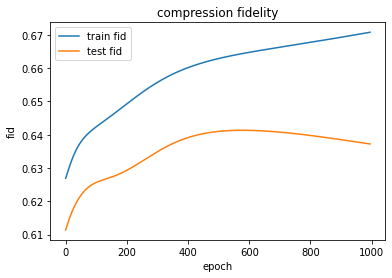

In [18]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")

plt.legend()
plt.title("compression fidelity",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.5098270365069932


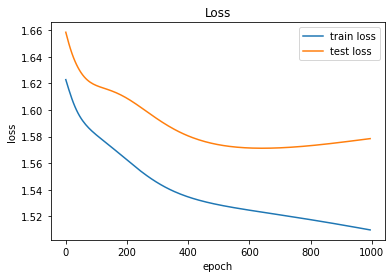

In [19]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Loss",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])